# 高维异常点检测算法

对于异常值检验的常用方法有：

1.基于数值的方法(IQR)：即通过上下α分位点之外的值认为是异常值（之前笔记中的boxplot可以检测)

2.基于距离、密度的方法，一般用于二维或高维中异常值的判别，也就是我们今天的主题LOF(其实我觉得这东西和DBSCAN的异常值检测有点像)，都是由密度来识别异常的

3.既不借助密度也不借助于距离的方法：孤立森林(Isolation Forest),该方法与随机森林(之前的笔记也有)有点像，但孤立森林的节点划分都是随机的，不是根据entropy和gini来的。在孤立森林建树的过程中，如果一些样本很快到达了叶子节点，那么很有可能被认为是异常点(因为叶子到根的距离d很短)

## 一、局部离群因子（LOF)
local outlier factor

定义:一个样本点周围的样本点所处位置的平均密度比上该样本点所在位置的密度。该式子是由6个算法步骤推导而来：1.k邻近距离。2.k距离领域。3.可达距离。(这里我没弄明白,大佬可以教下)4.局部可达密度。5.最后才是局部离群因子

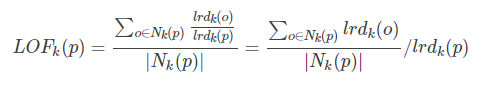

$设有p个原始变量x_i(i=1,2,\ldots,p),变量可能相关，可能独立，将x_i标准化得到新变量z_i，则可以建立因子分析模型：z_i=a_{i1}F_1+a_{i2}F_2+\ldots+a_{im}F_m+c_iU_i(i=1,2,\ldots,p),其中F_j(j=1,2,\ldots ,m)出现在每个变量的表达式中，称为公共因子,U_i(i=1,2,\ldots,p)仅和变量z_i有关，称为特殊因子，系数a_{ij},c_i(i=1,2,\ldots,p,j=1,2,\ldots,m)称为因子载荷,A=(a_{ij})称为载荷矩阵。即写为z=AF+CU,其中z=(z_1,z_2,\ldots,z_p)^T,F=(F_1,F_2,\ldots,F_m)^T,U=(U_1,U_2,\ldots,U_p)^T,A=(a_{ij})_{p\times m},C=diag(c_1,c_2,\ldots,c_p)$

$x_2$

$x_3$

核心算法步骤:

1.对于每个数据点，计算他与其他所有点的距离，并从近到远排序

2.接着每个数据点，找到他的K-Nearest-Neighbor-计算LOF得分

3.LOF值越大(大于1)，数据点为异常值,反之。

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_moons#生成玩具数据集
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf')
seaborn.set(font=myfont.get_name())
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
data=make_moons(n_samples=200,noise=0.5,random_state=1)
x=data[0]#我们就假装第一个特征为负债率，第二个特征为收益率

In [159]:
LOF=LocalOutlierFactor(n_neighbors=15)
label=LOF.fit_predict(x)
LOF_score=LOF.negative_outlier_factor_#这里的属性与LOF相反，值越小越容易成为异常值
x_all=np.c_[x,label,LOF_score]
x_df=pd.DataFrame(x_all,columns=['负债率','收益率','类别','负的LOF得分'])

In [160]:
x_df['类别']=x_df['类别'].map({-1:'异常点',1:'正常点'})

In [161]:
x_df.iloc[np.where(x_df['类别']=='异常点')]

,负债率,收益率,类别,负的LOF得分
1,0.540717,1.824439,异常点,-1.732243
19,-0.101279,2.060860,异常点,-1.519246
35,-1.039786,-0.855564,异常点,-1.612186
63,0.423643,1.710939,异常点,-1.550399
131,-1.363990,-0.498720,异常点,-1.539493
135,0.512454,1.606119,异常点,-1.506156
138,1.695476,-1.277068,异常点,-1.503963
158,0.924579,-1.604056,异常点,-1.787660


In [ ]:
#开始画图识别异常值
markers={'异常点':'s','正常点':'o'}
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(12,8),dpi=600)
seaborn.scatterplot(data=x_df,x='负债率',y='收益率',hue='类别',palette="deep",markers=markers,
                    style='类别',size='负的LOF得分',sizes=(20,200))
x_1=x_df.loc[np.where(x_df['类别']=='异常点'),'负债率']
x_2=x_df.loc[np.where(x_df['类别']=='异常点'),'收益率']
plt.scatter(x_1,x_2,marker='o',edgecolor='red',facecolors='none',s=200,linewidths=2)
plt.title('局部离群因子处理的异常值',fontsize=20)


## 二、孤立森林(Isolation forest)

定义:直接用稀疏程度来刻画，采用二叉树对数据进行分裂，样本选取、特征选取、分裂点选取(全部采用随机化的方式)。

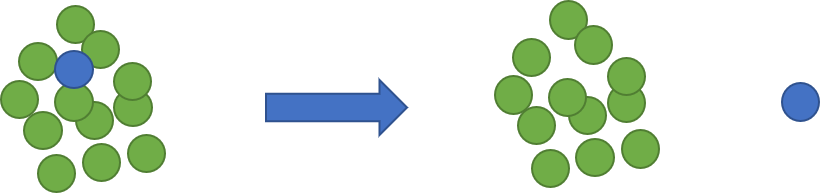

In [132]:
from sklearn.ensemble import IsolationForest
outlier=IsolationForest(n_estimators=100,contamination=0.1,
                       random_state=1)
outlier.fit(x)
y_pred=outlier.predict(x)

In [133]:
x_df_forest=pd.DataFrame(np.c_[x,y_pred],columns=['负债率','收益率','类别'])
x_df_forest['类别']=x_df_forest['类别'].map({-1:'异常点',1:'正常点'})
x_df_forest.iloc[np.where(x_df['类别']=='异常点')]

,负债率,收益率,类别
1,0.540717,1.824439,异常点
19,-0.101279,2.060860,异常点
35,-1.039786,-0.855564,异常点
131,-1.363990,-0.498720,异常点
158,0.924579,-1.604056,异常点


Text(0.5, 1.0, '孤立森林处理的异常值')

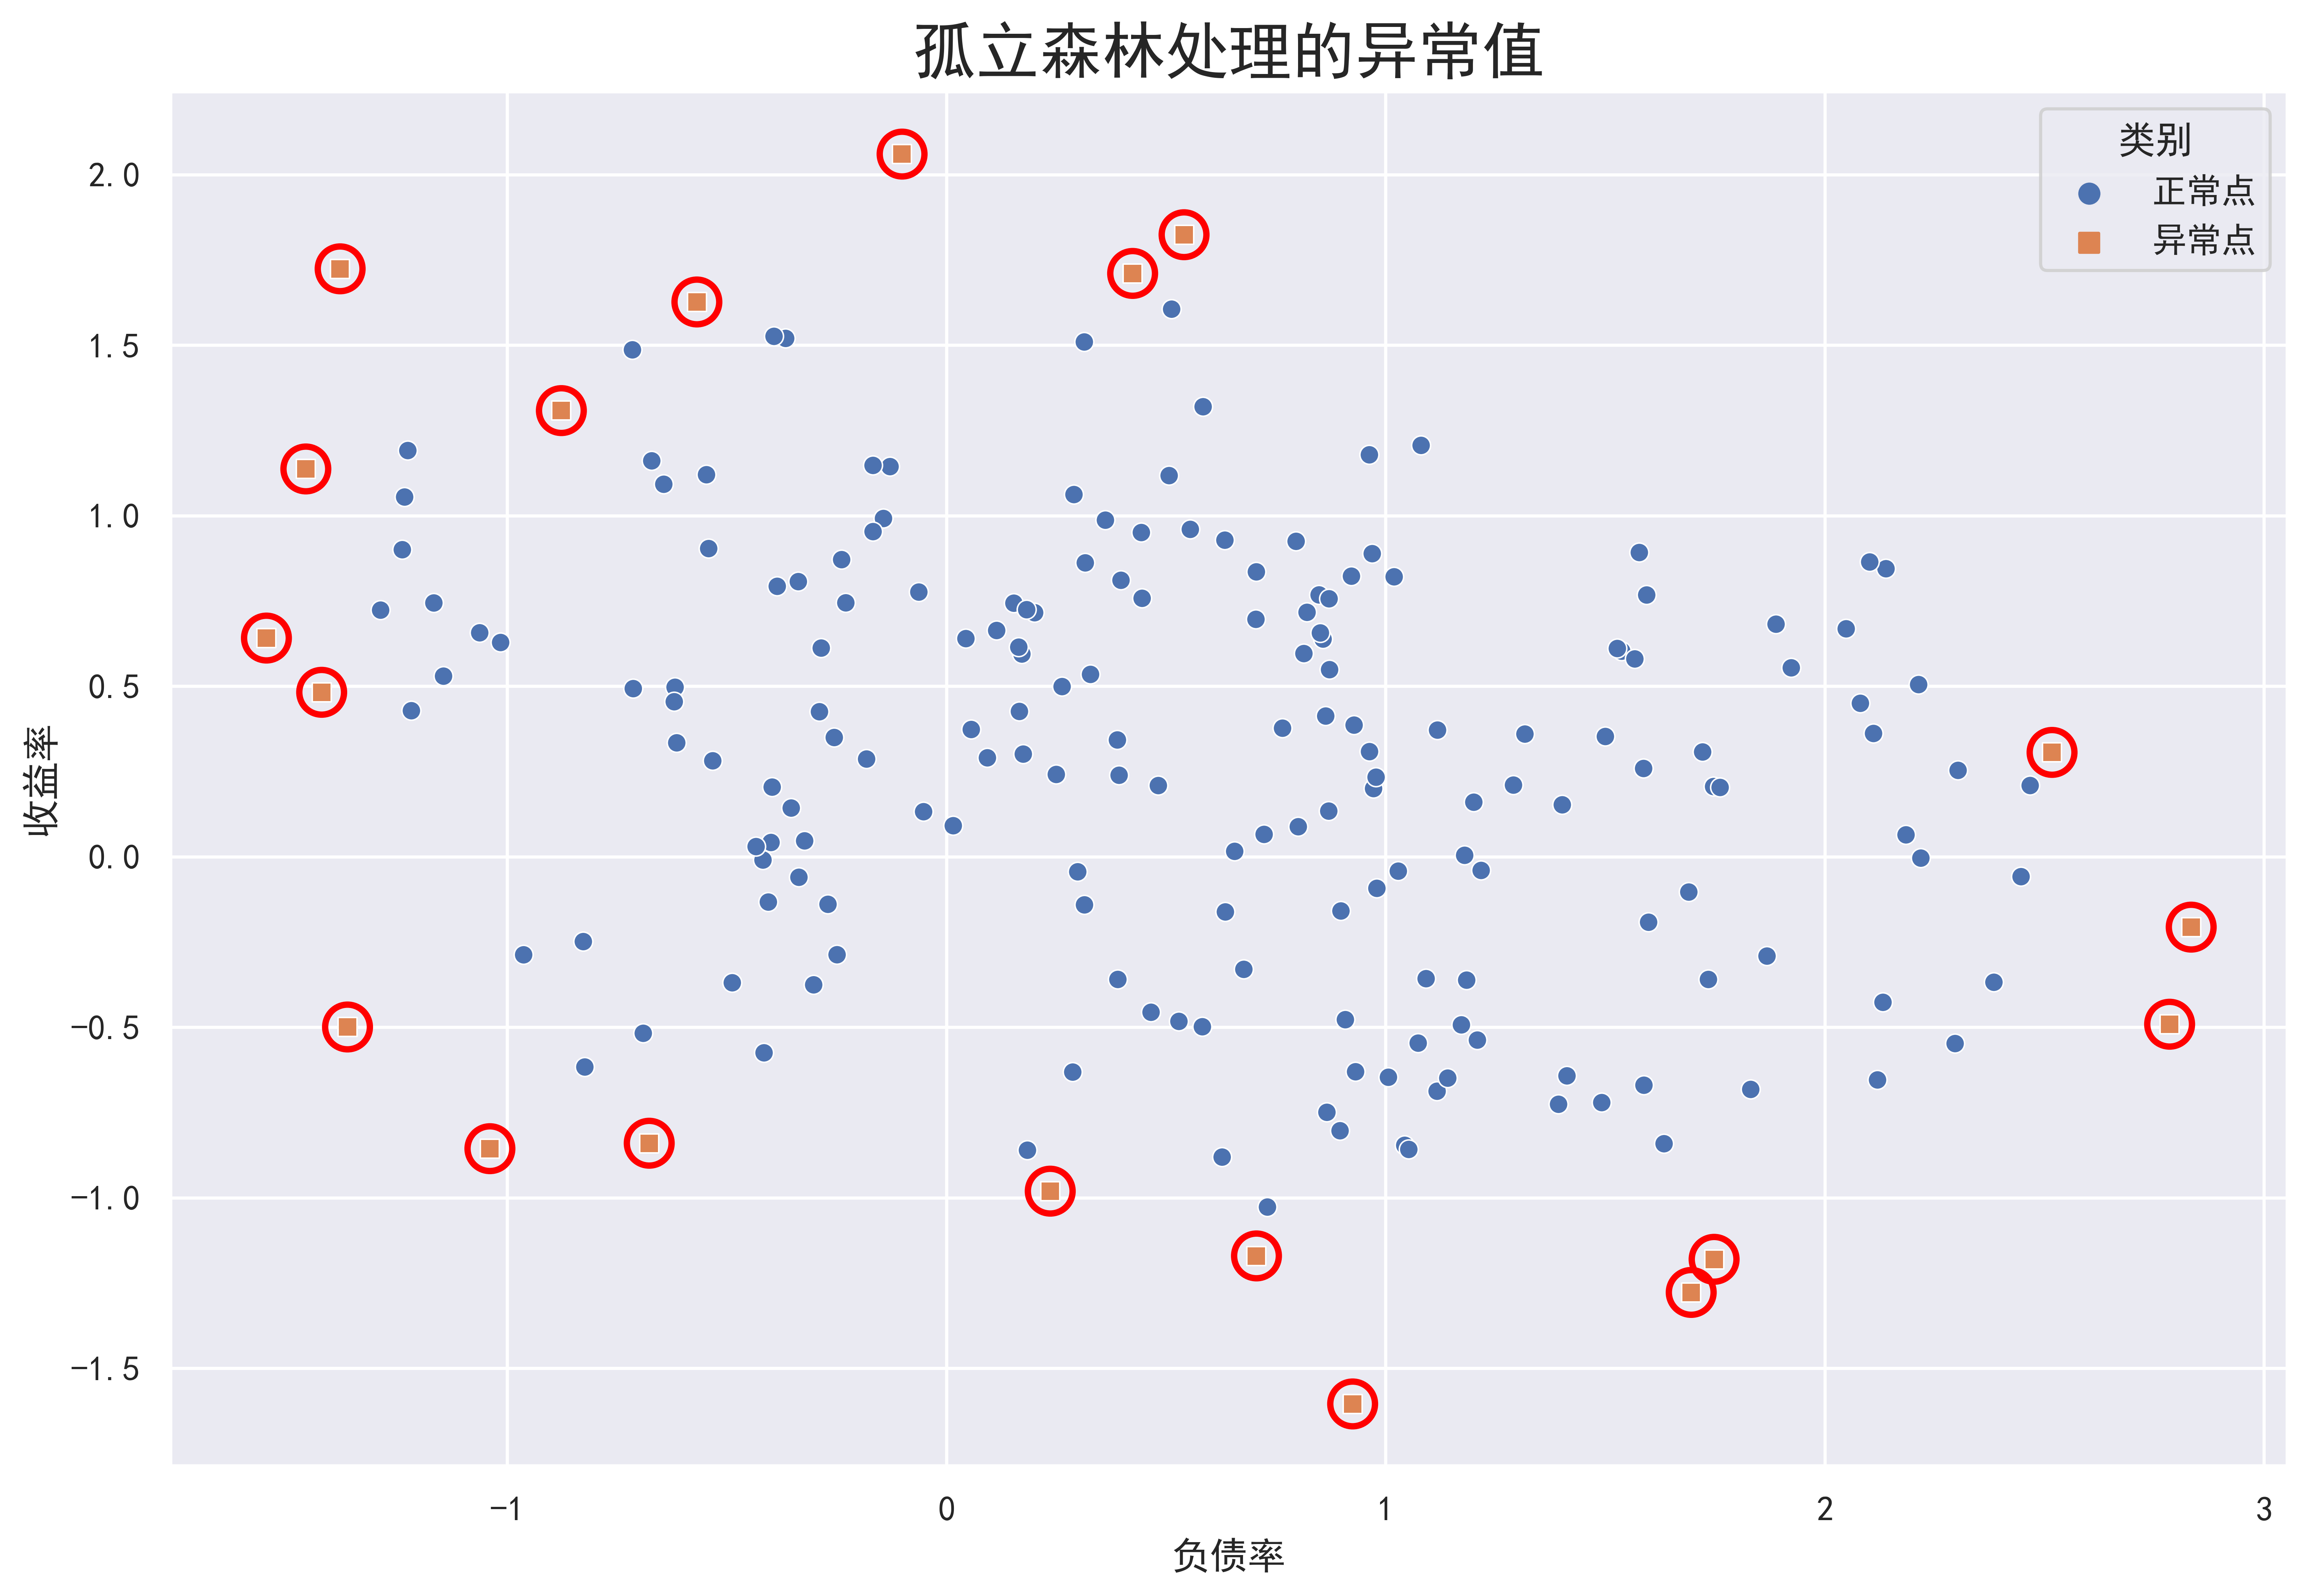

In [163]:
plt.figure(figsize=(12,8),dpi=600)
seaborn.scatterplot(data=x_df_forest,x='负债率',y='收益率',hue='类别',palette="deep",markers=markers,
                    style='类别')
x_1_forest=x_df_forest.loc[np.where(x_df_forest['类别']=='异常点'),'负债率']
x_2_forest=x_df_forest.loc[np.where(x_df_forest['类别']=='异常点'),'收益率']
plt.scatter(x_1_forest,x_2_forest,marker='o',edgecolor='red',facecolors='none',s=200,linewidths=2)
plt.title('孤立森林处理的异常值',fontsize=20)